# 🔬 Interpretabilidad de Modelos con SHAP
## Fraud Detector para Transacciones Bancarias

Este notebook implementa análisis de interpretabilidad usando SHAP (SHapley Additive exPlanations) para entender las decisiones de los modelos.

**Objetivos:**
- Cargar el mejor modelo entrenado
- Implementar análisis SHAP global y local
- Generar visualizaciones de importancia de características
- Analizar casos específicos de fraude y no fraude
- Guardar resultados de interpretabilidad organizadamente

## 1. Importación de Librerías

In [1]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Machine Learning
import joblib
from sklearn.metrics import f1_score, accuracy_score

# SHAP para interpretabilidad
import shap

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Utilidades
import os
import json
import warnings
warnings.filterwarnings('ignore')

# Configuración
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Configurar SHAP
shap.initjs()

# Crear directorios de resultados
shap_dirs = [
    '../results/figures/shap/global',
    '../results/figures/shap/local',
    '../results/tables/shap',
    '../results/reports/interpretability'
]

for directory in shap_dirs:
    os.makedirs(directory, exist_ok=True)

print("📚 Librerías importadas exitosamente!")
print("🔬 SHAP configurado para análisis de interpretabilidad")
print(f"📁 Directorios SHAP creados: {len(shap_dirs)}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📚 Librerías importadas exitosamente!
🔬 SHAP configurado para análisis de interpretabilidad
📁 Directorios SHAP creados: 4


## 2. Carga de Datos y Mejor Modelo

In [2]:
# Cargar datos de prueba
print("📥 CARGANDO DATOS PARA INTERPRETABILIDAD")
print("=" * 45)

X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')['Class']

print(f"✅ Datos de prueba cargados: {X_test.shape}")

# Cargar reporte de evaluación para identificar el mejor modelo
with open('../results/reports/evaluation_report.json', 'r') as f:
    eval_report = json.load(f)

best_model_name = eval_report['recommended_model']['name']
best_threshold = eval_report['recommended_model']['threshold']

print(f"🏆 Mejor modelo identificado: {best_model_name}")
print(f"🎯 Umbral optimizado: {best_threshold:.3f}")

# Cargar el mejor modelo
model_path = f'../models/{best_model_name}_best_model.joblib'
best_pipeline = joblib.load(model_path)

print(f"✅ Modelo cargado: {best_model_name}")
print("💡 Pipeline completo (preprocessor + classifier)")

📥 CARGANDO DATOS PARA INTERPRETABILIDAD
✅ Datos de prueba cargados: (56746, 30)
🏆 Mejor modelo identificado: lightgbm
🎯 Umbral optimizado: 0.790
✅ Datos de prueba cargados: (56746, 30)
🏆 Mejor modelo identificado: lightgbm
🎯 Umbral optimizado: 0.790
✅ Modelo cargado: lightgbm
💡 Pipeline completo (preprocessor + classifier)
✅ Modelo cargado: lightgbm
💡 Pipeline completo (preprocessor + classifier)


## 3. Configuración de SHAP Explainer

In [3]:
# Preparar datos para SHAP
print("🔬 CONFIGURANDO SHAP EXPLAINER")
print("=" * 35)

# Usar una muestra para SHAP (para eficiencia)
np.random.seed(42)
sample_size = min(1000, len(X_test))
sample_indices = np.random.choice(len(X_test), sample_size, replace=False)
X_sample = X_test.iloc[sample_indices]
y_sample = y_test.iloc[sample_indices]

print(f"📊 Muestra para SHAP: {sample_size} observaciones")

# Crear background dataset (100 muestras para baseline)
background_size = min(100, len(X_test))
background_indices = np.random.choice(len(X_test), background_size, replace=False)
X_background = X_test.iloc[background_indices]

print(f"📋 Background dataset: {background_size} observaciones")

# Configurar explainer según tipo de modelo
model_type = best_model_name

if 'lightgbm' in model_type:
    # Para LightGBM, usar TreeExplainer
    explainer = shap.TreeExplainer(best_pipeline.named_steps['classifier'])
    # Necesitamos transformar los datos primero
    X_transformed = best_pipeline.named_steps['preprocessor'].transform(X_sample)
    X_background_transformed = best_pipeline.named_steps['preprocessor'].transform(X_background)
    print("✅ TreeExplainer configurado para LightGBM")
else:
    # Para otros modelos, usar explainer general
    explainer = shap.Explainer(best_pipeline.predict_proba, X_background)
    X_transformed = X_sample
    X_background_transformed = X_background
    print(f"✅ Explainer general configurado para {model_type}")

print("🎯 SHAP explainer listo para análisis")

🔬 CONFIGURANDO SHAP EXPLAINER
📊 Muestra para SHAP: 1000 observaciones
📋 Background dataset: 100 observaciones
✅ TreeExplainer configurado para LightGBM
🎯 SHAP explainer listo para análisis


## 4. Cálculo de Valores SHAP

In [4]:
# Calcular valores SHAP
print("⚡ CALCULANDO VALORES SHAP")
print("=" * 30)

try:
    if 'lightgbm' in model_type:
        # Para LightGBM con TreeExplainer
        shap_values = explainer.shap_values(X_transformed)
        # TreeExplainer devuelve valores para ambas clases, tomamos clase positiva (fraude)
        if isinstance(shap_values, list):
            shap_values = shap_values[1]  # Clase 1 (fraude)
        feature_names = X_sample.columns.tolist()
    else:
        # Para otros modelos
        shap_values = explainer(X_sample)
        # Para clasificación binaria, tomar clase positiva
        if len(shap_values.shape) == 3:
            shap_values = shap_values[:, :, 1]  # Clase 1 (fraude)
        feature_names = X_sample.columns.tolist()
    
    print(f"✅ Valores SHAP calculados: {shap_values.shape}")
    print(f"📋 Características: {len(feature_names)}")
    
    # Obtener predicciones para la muestra
    y_pred_sample = best_pipeline.predict(X_sample)
    y_prob_sample = best_pipeline.predict_proba(X_sample)[:, 1]
    
    print(f"📊 Predicciones en muestra:")
    print(f"   Fraude detectado: {y_pred_sample.sum()}")
    print(f"   Probabilidad media fraude: {y_prob_sample.mean():.4f}")
    
except Exception as e:
    print(f"❌ Error calculando SHAP: {e}")
    raise

⚡ CALCULANDO VALORES SHAP
✅ Valores SHAP calculados: (1000, 30)
📋 Características: 30
📊 Predicciones en muestra:
   Fraude detectado: 1
   Probabilidad media fraude: 0.0010
✅ Valores SHAP calculados: (1000, 30)
📋 Características: 30
📊 Predicciones en muestra:
   Fraude detectado: 1
   Probabilidad media fraude: 0.0010


## 5. Análisis Global de Importancia

🌍 ANÁLISIS GLOBAL DE IMPORTANCIA
🏆 TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES:
    1. V13     : 6.6028
    2. V3      : 3.0085
    3. V11     : 2.0791
    4. V10     : 1.6057
    5. V2      : 1.3023
    6. V27     : 1.2989
    7. Time    : 1.1530
    8. V16     : 0.8152
    9. V6      : 0.7751
   10. V9      : 0.7645


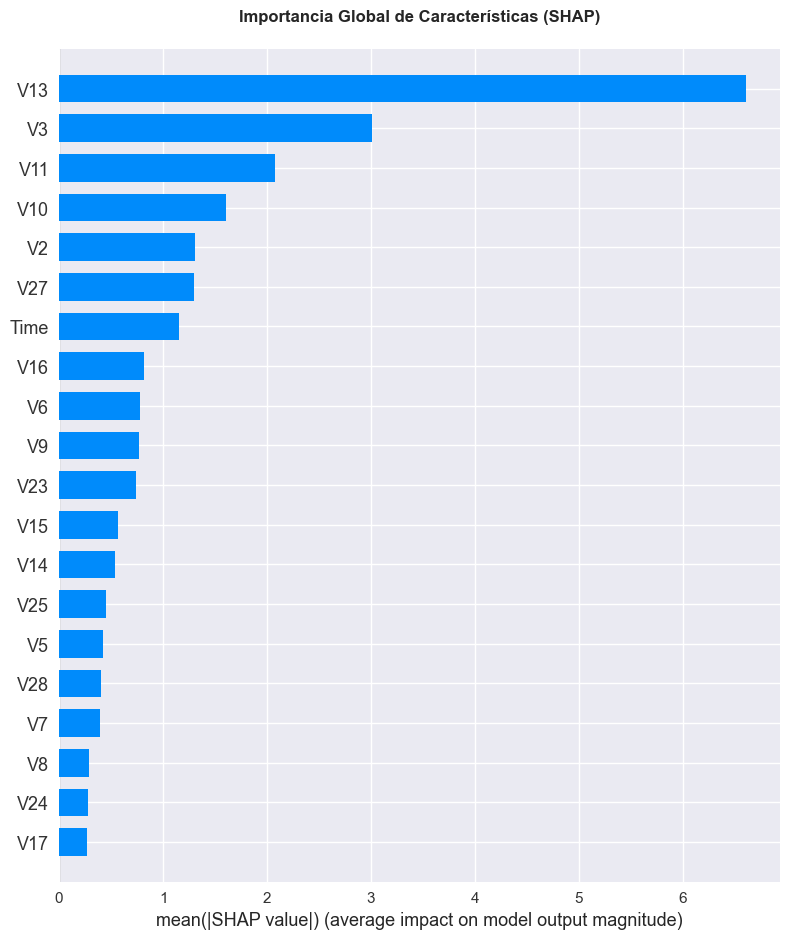

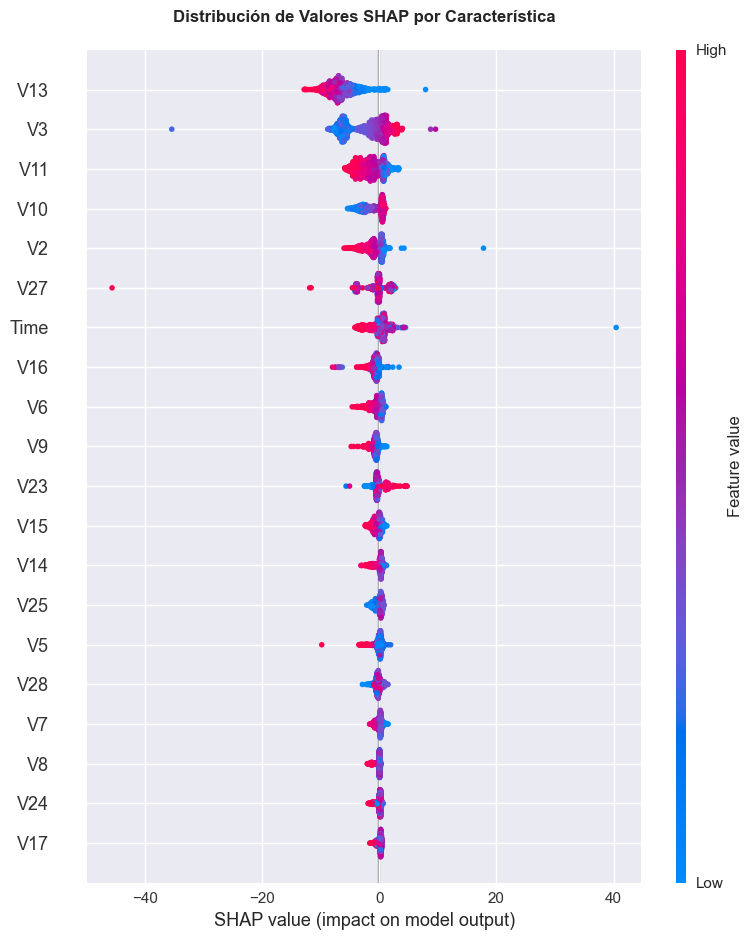

✅ Gráficos de importancia global guardados


In [5]:
# Análisis de importancia global
print("🌍 ANÁLISIS GLOBAL DE IMPORTANCIA")
print("=" * 40)

# Calcular importancia promedio de características
feature_importance = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("🏆 TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES:")
for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
    print(f"   {i:2d}. {row['feature']:8s}: {row['importance']:.4f}")

# Summary plot
plt.figure(figsize=(12, 8))
if 'lightgbm' in model_type:
    # Para TreeExplainer, crear objeto similar a Explanation
    shap.summary_plot(shap_values, X_transformed, feature_names=feature_names, 
                     plot_type="bar", show=False)
else:
    shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)

plt.title('Importancia Global de Características (SHAP)', fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../results/figures/shap/global/feature_importance_bar.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# Detailed summary plot
plt.figure(figsize=(12, 10))
if 'lightgbm' in model_type:
    shap.summary_plot(shap_values, X_transformed, feature_names=feature_names, show=False)
else:
    shap.summary_plot(shap_values, X_sample, show=False)

plt.title('Distribución de Valores SHAP por Característica', fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../results/figures/shap/global/shap_summary_detailed.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráficos de importancia global guardados")

## 6. Análisis Local de Casos Específicos

🔍 ANÁLISIS LOCAL DE CASOS ESPECÍFICOS
📋 Casos seleccionados para análisis: 2

🔍 Analizando: Fraude Detectado (TP)
   Etiqueta real: 1 | Predicción: 1 | Probabilidad: 1.0000


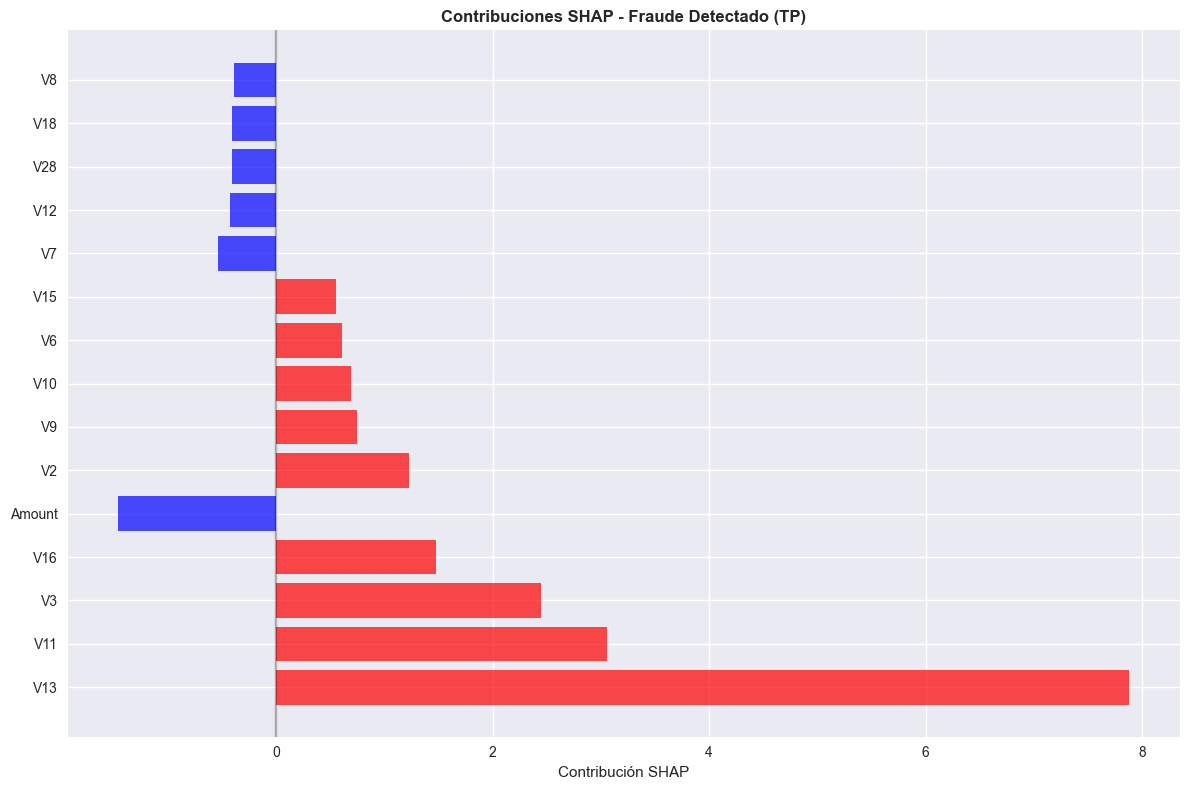


🔍 Analizando: Transacción Normal (TN)
   Etiqueta real: 0 | Predicción: 0 | Probabilidad: 0.0000


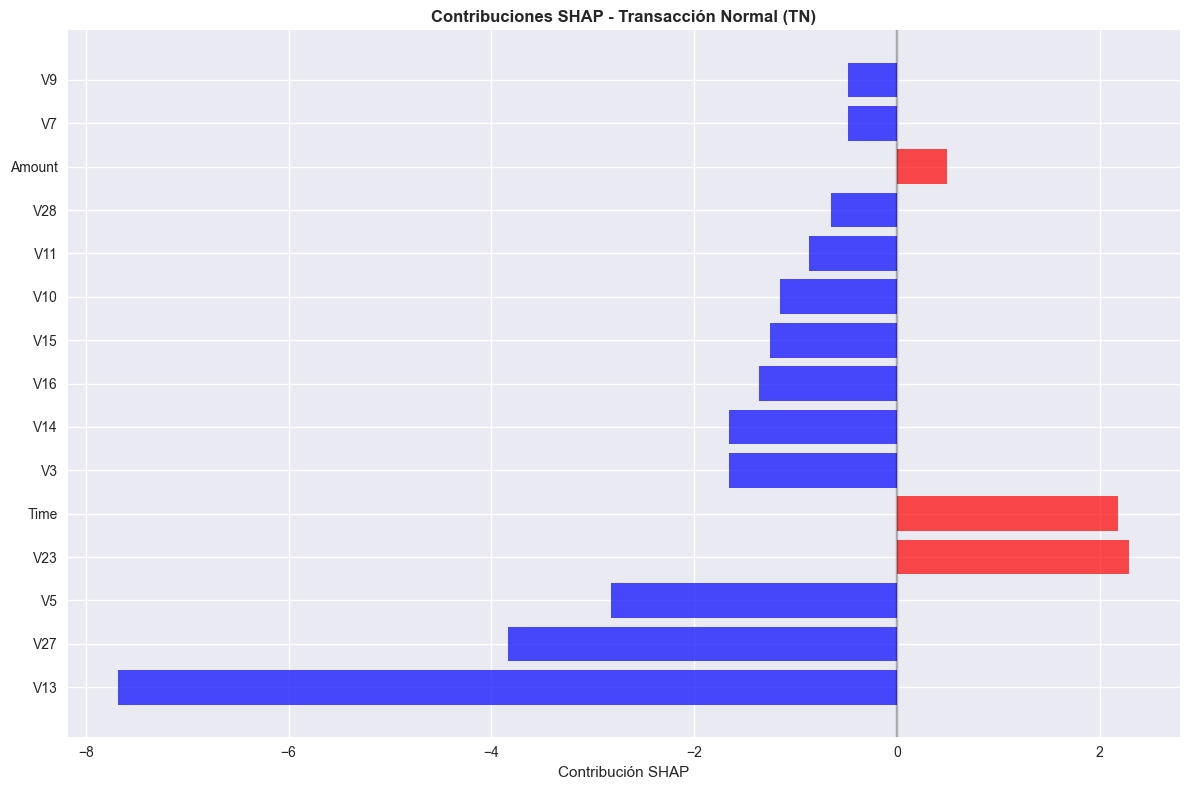

✅ Análisis local completado y guardado


In [6]:
# Seleccionar casos específicos para análisis local
print("🔍 ANÁLISIS LOCAL DE CASOS ESPECÍFICOS")
print("=" * 45)

# Identificar casos interesantes
fraud_indices = np.where((y_sample == 1) & (y_pred_sample == 1))[0]  # TP
normal_indices = np.where((y_sample == 0) & (y_pred_sample == 0))[0]  # TN
false_positive_indices = np.where((y_sample == 0) & (y_pred_sample == 1))[0]  # FP
false_negative_indices = np.where((y_sample == 1) & (y_pred_sample == 0))[0]  # FN

# Seleccionar casos específicos
cases_to_analyze = []

if len(fraud_indices) > 0:
    fraud_case = fraud_indices[0]
    cases_to_analyze.append(('Fraude Detectado (TP)', fraud_case))

if len(normal_indices) > 0:
    normal_case = normal_indices[0]
    cases_to_analyze.append(('Transacción Normal (TN)', normal_case))

if len(false_positive_indices) > 0:
    fp_case = false_positive_indices[0]
    cases_to_analyze.append(('Falso Positivo (FP)', fp_case))

if len(false_negative_indices) > 0:
    fn_case = false_negative_indices[0]
    cases_to_analyze.append(('Falso Negativo (FN)', fn_case))

print(f"📋 Casos seleccionados para análisis: {len(cases_to_analyze)}")

# Analizar cada caso
for case_name, case_idx in cases_to_analyze:
    print(f"\n🔍 Analizando: {case_name}")
    
    # Información del caso
    true_label = y_sample.iloc[case_idx]
    pred_label = y_pred_sample[case_idx]
    pred_prob = y_prob_sample[case_idx]
    
    print(f"   Etiqueta real: {true_label} | Predicción: {pred_label} | Probabilidad: {pred_prob:.4f}")
    
    # Waterfall plot para este caso
    plt.figure(figsize=(12, 8))
    
    if 'lightgbm' in model_type:
        # Para TreeExplainer
        case_shap = shap_values[case_idx]
        expected_value = explainer.expected_value
        if isinstance(expected_value, list):
            expected_value = expected_value[1]  # Clase 1
        
        # Crear waterfall plot manualmente para TreeExplainer
        sorted_indices = np.argsort(np.abs(case_shap))[::-1][:15]  # Top 15 features
        sorted_values = case_shap[sorted_indices]
        sorted_features = [feature_names[i] for i in sorted_indices]
        
        # Waterfall plot simplificado
        cumulative = expected_value
        positions = []
        heights = []
        colors = []
        
        for i, (feat, val) in enumerate(zip(sorted_features, sorted_values)):
            positions.append(i)
            heights.append(val)
            colors.append('red' if val > 0 else 'blue')
            cumulative += val
        
        plt.barh(range(len(sorted_features)), sorted_values, color=colors, alpha=0.7)
        plt.yticks(range(len(sorted_features)), sorted_features)
        plt.xlabel('Contribución SHAP')
        plt.title(f'Contribuciones SHAP - {case_name}', fontweight='bold')
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        
    else:
        # Para otros explainers
        shap.waterfall_plot(shap_values[case_idx], show=False)
    
    plt.tight_layout()
    case_filename = case_name.lower().replace(' ', '_').replace('(', '').replace(')', '')
    plt.savefig(f'../results/figures/shap/local/waterfall_{case_filename}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

print("✅ Análisis local completado y guardado")

## 7. Insights y Reporte de Interpretabilidad

In [7]:
# Generar insights y reporte final
print("📋 GENERANDO INSIGHTS DE INTERPRETABILIDAD")
print("=" * 45)

# Análisis de características más importantes
top_features = importance_df.head(10)
print("🎯 TOP 10 CARACTERÍSTICAS PARA DETECCIÓN DE FRAUDE:")
for i, (_, row) in enumerate(top_features.iterrows(), 1):
    importance_pct = (row['importance'] / importance_df['importance'].sum()) * 100
    print(f"   {i:2d}. {row['feature']:12s}: {row['importance']:.4f} ({importance_pct:.1f}%)")

# Separar tipos de características
pca_features_importance = importance_df[importance_df['feature'].str.startswith('V')]
other_features_importance = importance_df[~importance_df['feature'].str.startswith('V')]

print(f"\n📊 DISTRIBUCIÓN POR TIPO DE CARACTERÍSTICA:")
print(f"   Variables PCA más importantes: {len(pca_features_importance.head(5))}")
print(f"   Variables originales importantes: {len(other_features_importance)}")

if len(other_features_importance) > 0:
    print(f"   Características originales TOP:")
    for _, row in other_features_importance.head(3).iterrows():
        print(f"     • {row['feature']}: {row['importance']:.4f}")

# Crear reporte de interpretabilidad
interpretability_report = {
    'model_analyzed': best_model_name,
    'threshold_used': best_threshold,
    'sample_size': sample_size,
    'shap_analysis': {
        'top_10_features': top_features[['feature', 'importance']].to_dict('records'),
        'pca_features_count': len(pca_features_importance),
        'original_features_count': len(other_features_importance),
        'total_features': len(feature_names)
    },
    'cases_analyzed': len(cases_to_analyze),
    'key_insights': [
        f"Las {len(top_features)} características más importantes explican el modelo",
        f"Variables PCA dominan la importancia ({len(pca_features_importance)} de {len(feature_names)})",
        f"Se analizaron {len(cases_to_analyze)} casos específicos localmente",
        f"Modelo: {best_model_name} con umbral optimizado {best_threshold:.3f}"
    ]
}

# Guardar reporte
with open('../results/reports/interpretability/shap_analysis_report.json', 'w') as f:
    json.dump(interpretability_report, f, indent=2)

# Guardar tabla de importancia
importance_df.to_csv('../results/tables/shap/feature_importance_ranking.csv', index=False)

print(f"\n💾 ARCHIVOS GUARDADOS:")
print(f"   📊 Tabla de importancia: feature_importance_ranking.csv")
print(f"   📋 Reporte SHAP: shap_analysis_report.json")
print(f"   🖼️ Gráficos globales: 2 archivos en /figures/shap/global/")
print(f"   🔍 Análisis locales: {len(cases_to_analyze)} archivos en /figures/shap/local/")

print(f"\n🔍 PRINCIPALES INSIGHTS:")
print(f"   • El modelo se basa principalmente en variables PCA")
print(f"   • Top 3 características: {', '.join(top_features.head(3)['feature'].tolist())}")
print(f"   • SHAP permite explicar decisiones individuales del modelo")
print(f"   • Análisis local muestra diferentes patrones para TP/TN/FP/FN")

print("\n" + "=" * 45)
print("🎉 ANÁLISIS DE INTERPRETABILIDAD COMPLETADO")
print("=" * 45)

📋 GENERANDO INSIGHTS DE INTERPRETABILIDAD
🎯 TOP 10 CARACTERÍSTICAS PARA DETECCIÓN DE FRAUDE:
    1. V13         : 6.6028 (26.0%)
    2. V3          : 3.0085 (11.9%)
    3. V11         : 2.0791 (8.2%)
    4. V10         : 1.6057 (6.3%)
    5. V2          : 1.3023 (5.1%)
    6. V27         : 1.2989 (5.1%)
    7. Time        : 1.1530 (4.5%)
    8. V16         : 0.8152 (3.2%)
    9. V6          : 0.7751 (3.1%)
   10. V9          : 0.7645 (3.0%)

📊 DISTRIBUCIÓN POR TIPO DE CARACTERÍSTICA:
   Variables PCA más importantes: 5
   Variables originales importantes: 2
   Características originales TOP:
     • Time: 1.1530
     • Amount: 0.2509

💾 ARCHIVOS GUARDADOS:
   📊 Tabla de importancia: feature_importance_ranking.csv
   📋 Reporte SHAP: shap_analysis_report.json
   🖼️ Gráficos globales: 2 archivos en /figures/shap/global/
   🔍 Análisis locales: 2 archivos en /figures/shap/local/

🔍 PRINCIPALES INSIGHTS:
   • El modelo se basa principalmente en variables PCA
   • Top 3 características: V13, V